In [1]:
import os
import keras


In [15]:
from keras.applications import inception_v3 as inc_net
#from keras.preprocessing import image
import keras.utils as image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.9.0


## Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with preprocessing tools. 

In [4]:
inet_model = inc_net.InceptionV3()

96112376/96112376 [==============================] - 1s 0us/step


In [5]:
def transform_img_fn(path_list): 
  out = []
  for img_path in path_list:
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inc_net.preprocess_input(x)
    out.append(x)
  return np.vstack(out)

Let us see the top 5 prediction for a single image.

In [12]:
import requests 
f = open('cat_mouse.jpg', 'wb')
f.write(requests.get("https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg").content)
f.close()

In [16]:
images = transform_img_fn(['cat_mouse.jpg'])

In [17]:
images.shape

(1, 299, 299, 3)

35363/35363 [==============================] - 0s 0us/step
('n02133161', 'American_black_bear', 0.6371599)
('n02105056', 'groenendael', 0.031818066)
('n02104365', 'schipperke', 0.029944316)
('n01883070', 'wombat', 0.028509468)
('n01877812', 'wallaby', 0.025093513)


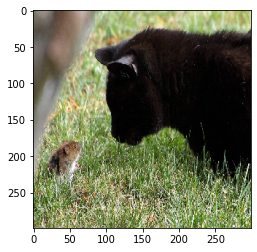

In [18]:
plt.imshow(images[0]/2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]: 
  print(x)

## Explanation

In [21]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 34.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d7ff67ace14f70ca4f067f041de614c8f5244283a4b8795b69225b51b83d83b9
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [22]:
%load_ext autoreload
%autoreload 2
import os, sys
try: 
  import lime 
except: 
  sys.path.append(os.path.join('..','..'))
  import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
explainer = lime_image.LimeImageExplainer()

In [24]:
%%time 
explanation = explainer.explain_instance(
    images[0].astype('double'),
    inet_model.predict,
    top_labels = 5, 
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
CPU times: user 6min 11s, sys: 5.96 s, total: 6min 17s
Wall time: 4min 11s


We can see the top 5 superpixels that are most positive towards the cass with the rest of the image hidden.

In [25]:
from skimage.segmentation import mark_boundaries

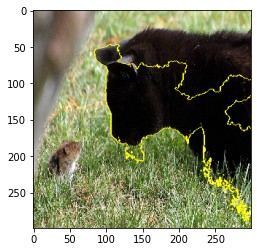

In [28]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only = True, 
    num_features = 5, 
    hide_rest = False
)

plt.imshow(mark_boundaries(temp/2+0.5, mask))

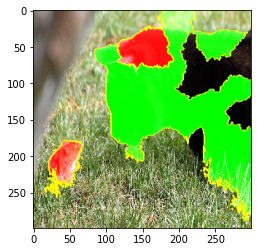

In [29]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only = False, 
    num_features = 10, 
    hide_rest = False
)

plt.imshow(mark_boundaries(temp/2+0.5, mask))

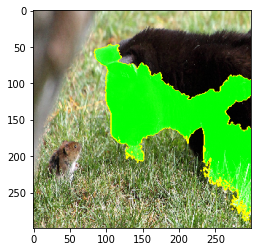

In [30]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only = False, 
    num_features = 1000, 
    hide_rest = False,
    min_weight=0.1
)

plt.imshow(mark_boundaries(temp/2+0.5, mask))

In [31]:
ind = explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

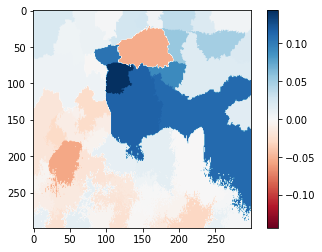

In [32]:
plt.imshow(heatmap, cmap = 'RdBu', vmin = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [39]:
decode_predictions(preds)[0]

[('n02133161', 'American_black_bear', 0.6371599),
 ('n02105056', 'groenendael', 0.031818066),
 ('n02104365', 'schipperke', 0.029944316),
 ('n01883070', 'wombat', 0.028509468),
 ('n01877812', 'wallaby', 0.025093513)]

In [34]:
explanation.top_labels[0:5]

[295, 224, 223, 106, 104]

Let us see explanation for another prediction: Wombat with index=106.

In [35]:
ind = explanation.top_labels[3]

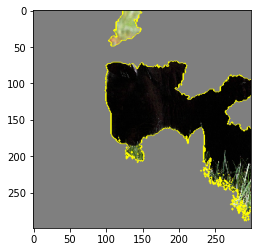

In [37]:
temp, mask = explanation.get_image_and_mask(
    ind, 
    positive_only=True, 
    num_features=5, 
    hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


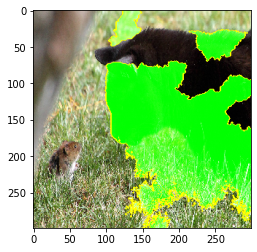

In [36]:
temp, mask = explanation.get_image_and_mask(
    ind, 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


## References
1. LIME-image with Keras example: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb